In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/tweetsentiment/sample_submission.csv
/kaggle/input/tweetsentiment/train.csv
/kaggle/input/tweetsentiment/test.csv


In [2]:

# utilities
import re
import numpy as np
import pandas as pd
import string
from collections import Counter
#import contractions

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

# visulization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"i'd": "i had / i would",
"i`d": "i had / i would",
"i'd've": "i would have",
"i'll": "i shall / i will",
"i'll've": "i shall have / i will have",
"i'm": "i am",
"i`m": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"it`s": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}


In [4]:
test_data=pd.read_csv("/kaggle/input/tweetsentiment/test.csv")
train_data=pd.read_csv("/kaggle/input/tweetsentiment/train.csv")
train_data.head(3)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative


In [5]:
test_data.head(3)

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative


## Exploratory data anlysis

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
np.sum(train_data.isnull().any(axis=1))

1

In [8]:
np.sum(test_data.isnull().any(axis=1))

0

In [9]:
train_data=train_data.dropna()

<AxesSubplot:xlabel='sentiment', ylabel='count'>

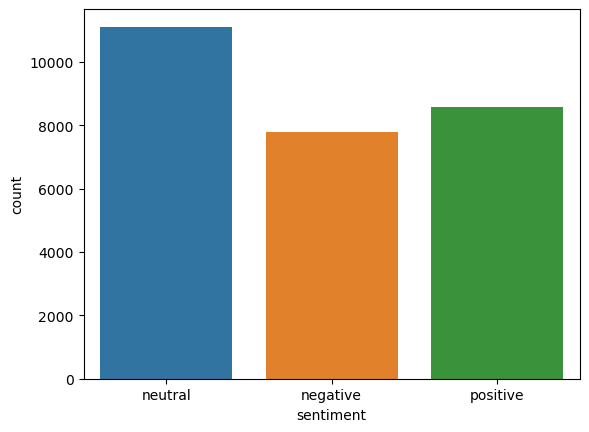

In [10]:
# check for label values, helps to figure out imbalanced classes
import seaborn as sns
sns.countplot(x='sentiment', data=train_data)

In [11]:
# check the number of positive vs. negative tagged sentences
positives = train_data['sentiment'][train_data.sentiment == 'positive']
negatives = train_data['sentiment'][train_data.sentiment == 'negative']
neutral = train_data['sentiment'][train_data.sentiment == 'neutral']
print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('number of neutral tagged sentences is: {}'.format(len(neutral)))
print('total length of the data is:            {}'.format(train_data.shape[0]))

number of positve tagged sentences is:  8582
number of negative tagged sentences is: 7781
number of neutral tagged sentences is: 11117
total length of the data is:            27480


In [12]:
# get a word count per sentence column
def word_count(sentence):
    #print(sentence)
    return len(sentence.split())
    
train_data.loc[:,'word count'] = train_data['text'].apply(word_count)
train_data.head(3)

,textID,text,selected_text,sentiment,word count
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


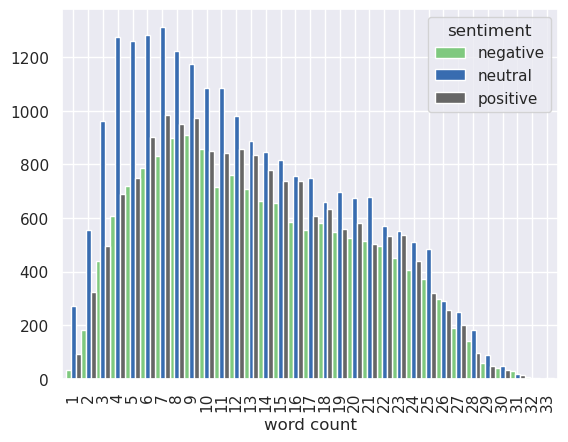

In [13]:
seaborn.set() 
#plt.figure(figsize=(20,8))

df = train_data[['word count','sentiment']]
df.loc[:,'dummy'] = 2
ag = df.groupby(['word count','sentiment']).sum().unstack()
ag.columns = ag.columns.droplevel()
ag.plot(kind = 'bar', colormap = cm.Accent, width = 1)
plt.show()

In [14]:
# get most common words in training dataset

all_words = []

for line in list(train_data['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('i', 13065),
 ('to', 9943),
 ('the', 8946),
 ('a', 6684),
 ('my', 5489),
 ('and', 5010),
 ('you', 4201),
 ('is', 3903),
 ('in', 3690),
 ('for', 3635)]

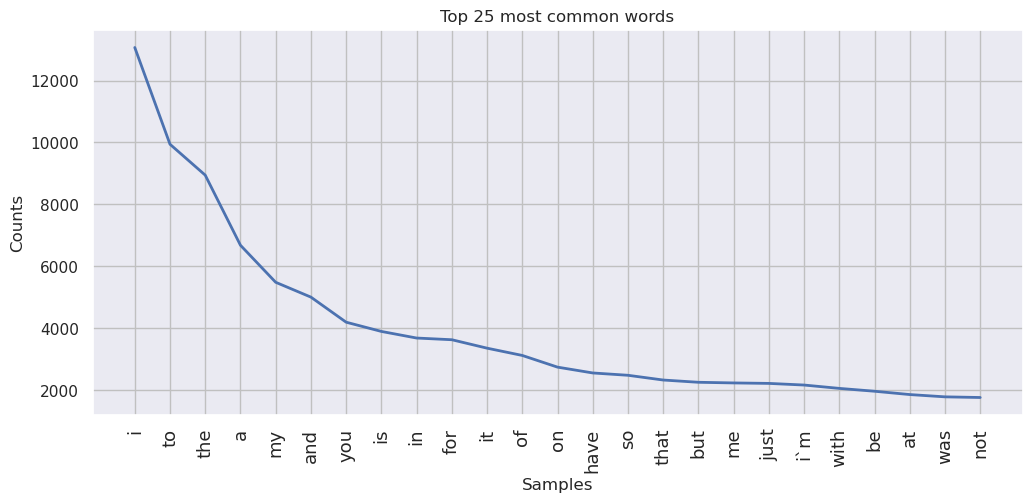

Text(0.5, 1.0, 'log-log plot of words frequency')

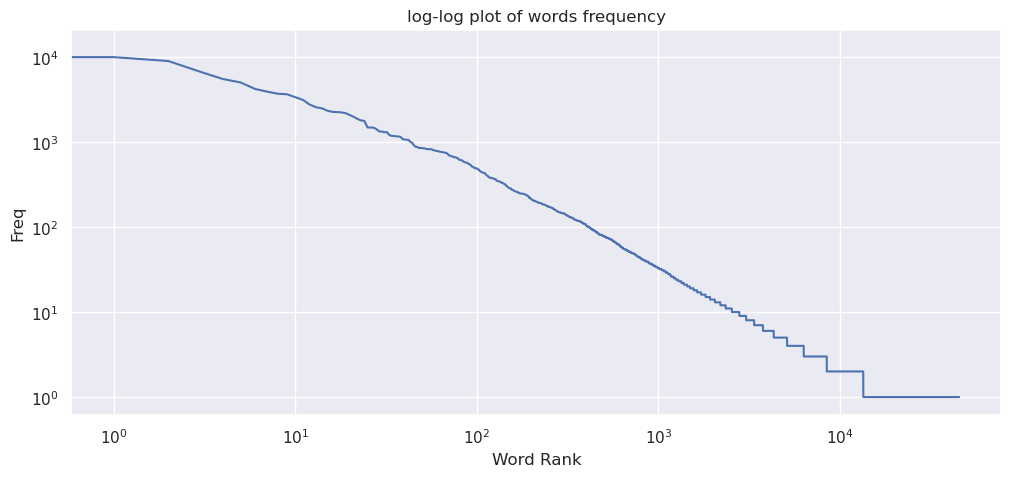

In [15]:
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)


# log-log plot
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

## Data preprocessing

In [16]:
train_data.loc[:,'text']=train_data['text'].str.lower()
train_data.loc[:,'sentiment']=train_data['sentiment'].str.lower()

In [17]:
def remove_contractions(text):
    for word in str(text).split():
        if word in contractions:
            text = text.replace(word, contractions[word.lower()])
    return text

train_data['text'] = train_data['text'].apply(lambda text: remove_contractions(text))
train_data['sentiment'] = train_data['sentiment'].apply(lambda text: remove_contractions(text))
train_data['text'].head(3)

0     i had / i would have responded, if i were going
1       sooo sad i will miss you here in san diego!!!
2                           my boss is bullying me...
Name: text, dtype: object

In [18]:
stopwords = nltk.corpus.stopwords.words('english')
list(stopwords)[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [19]:
# remove the stop words from the text
STOPWORDS = set(stopwords)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

train_data['text'] = train_data['text'].apply(lambda text: cleaning_stopwords(text))
train_data['sentiment'] = train_data['sentiment'].apply(lambda text: cleaning_stopwords(text))
train_data['text'].head(3)

0      / would responded, going
1    sooo sad miss san diego!!!
2           boss bullying me...
Name: text, dtype: object

In [20]:
# remove the URLs from the text
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)

train_data['text'] = train_data['text'].apply(lambda x: cleaning_URLs(x))
train_data['sentiment'] = train_data['sentiment'].apply(lambda x: cleaning_URLs(x))
train_data['text'].head(3)

0      / would responded, going
1    sooo sad miss san diego!!!
2           boss bullying me...
Name: text, dtype: object

In [21]:
# remove the punctuations from the text
punctuations_list = string.punctuation

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

train_data['text'] = train_data['text'].apply(lambda x: cleaning_punctuations(x))
train_data['sentiment'] = train_data['sentiment'].apply(lambda x: cleaning_punctuations(x))
train_data['text'].head(3)

0      would responded going
1    sooo sad miss san diego
2           boss bullying me
Name: text, dtype: object

In [22]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)

train_data['text'] = train_data['text'].apply(lambda x: cleaning_repeating_char(x))
train_data['sentiment'] = train_data['sentiment'].apply(lambda x: cleaning_repeating_char(x))
train_data['text'].head(3)

0      would responded going
1    sooo sad miss san diego
2           boss bullying me
Name: text, dtype: object

In [23]:
# Remove numbers from the text
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

train_data['text'] = train_data['text'].apply(lambda x: cleaning_numbers(x))
train_data['sentiment'] = train_data['sentiment'].apply(lambda x: cleaning_numbers(x))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
train_data['text'].head(3)

0      would responded going
1    sooo sad miss san diego
2           boss bullying me
Name: text, dtype: object

In [24]:
def remove_letters(text):
    return ' '.join( [w for w in  str(text).split() if len(w)>1] )


train_data['text'] = train_data['text'].apply(lambda x: remove_letters(x))
train_data['sentiment'] = train_data['sentiment'].apply(lambda x: remove_letters(x))
train_data['text'].head(3)

0      would responded going
1    sooo sad miss san diego
2           boss bullying me
Name: text, dtype: object

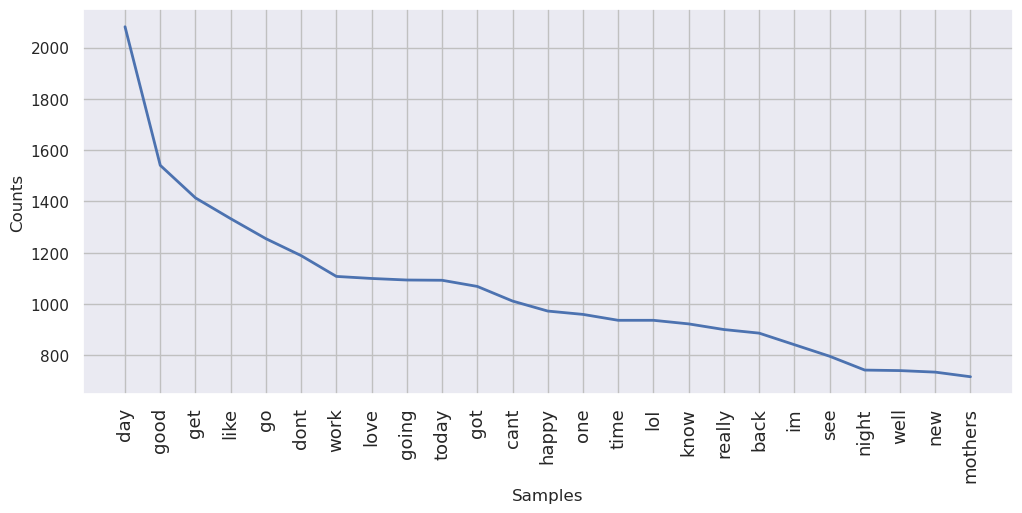

Text(0.5, 0, 'Word Rank')

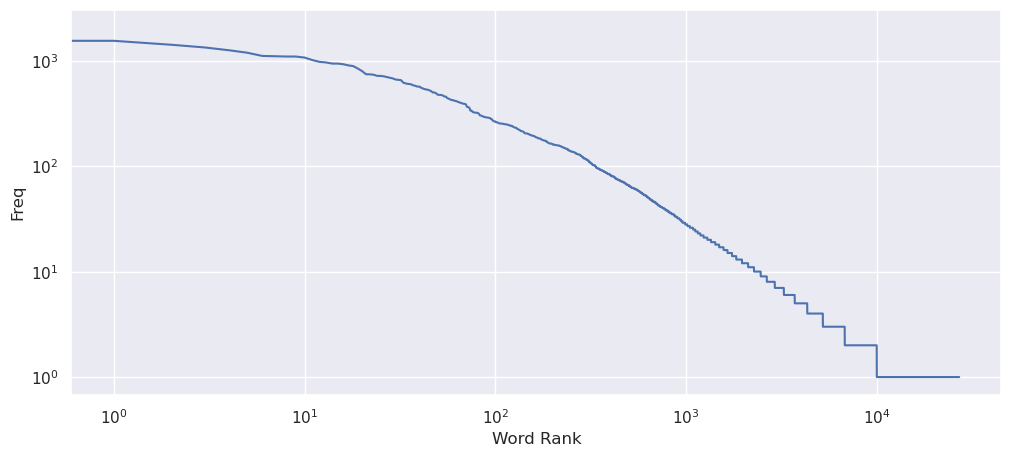

In [25]:
# most common words in twitter dataset
all_words = []
for line in list(train_data['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
        
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")